In [12]:
"""
Created on Thu Oct 14 17:31:50 2021

@author: Ben
"""

#Ben McAteer Midterm Project BME 511

import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd

#from sklearn.decomposition import PCA
#from scipy import signal
from scipy.io import loadmat
from numpy.fft import fft, ifft
#from scipy.signal import find_peaks
#from scipy import linalg

import glob
import os

NumTrials = 6
fs = 2048 #Hz sample rate

data1 = {}
events1 = {}
stimuli1 = {}
target1 = {}
targets_counted1 = {}

In [13]:
def SST (Subject,Session,Trial,count): # pulls all matlab files for a specific subject in order from session 1 first run to the final session
    
    os.chdir('/Users\Ben\OneDrive - purdue.edu\BME 511\MidtermProject\AllSubjsEEG\subject{}\session{}'.format(Subject,Session))
    mat_files = glob.glob('*.mat')
    #print(mat_files) #troubleshoot
    currentTrial = loadmat(mat_files[Trial], squeeze_me = True)
    
    
    
    currentfile = 'data' + str(count)
    
    data1[currentfile] = currentTrial['data'] #raw data of the current trial
    events1[currentfile] = currentTrial['events']
    stimuli1[currentfile] = currentTrial['stimuli']
    target1[currentfile] = currentTrial['target']
    targets_counted1[currentfile] = currentTrial['targets_counted']
    
    # print('data size', np.shape(Trial['data']))
    # print('events size', np.shape(Trial['events']))
    # print('stimuli size', np.shape(Trial['stimuli']))
    # print('target ', (Trial['target']))
    # print('targetcounted ', (Trial['targets_counted']))
    
    # for key, value in data.items():
    #    print(key)
        
    
    return(data1,events1,stimuli1,target1,targets_counted1)

In [14]:
def unpackStamp(x):
    y = np.int32(x[0])
    mo = np.int32(x[1])
    d = np.int32(x[2])
    h = np.int32(x[3])
    mi = np.int32(x[4])
    s = x[5]
    s_new = np.int32(np.floor(s))
    micros = np.int32((s - s_new) * 1e6)
    unpacked = datetime.datetime(y, mo, d, h, mi, s_new, micros)
    return unpacked


def events2samps(events, fs):
    firsteve_time = 0.4
    Nevents = events.shape[0]
    evesamps = np.zeros(Nevents)
    for k in range(Nevents):
        td =  unpackStamp(events[k, :]) - unpackStamp(events[0, :])
        evesamps[k] = np.int32(np.round(td.total_seconds()*fs + firsteve_time*fs + 1))
    
    return evesamps

In [15]:
#1A
#from numpy.fft import fft, ifft
from scipy import signal
import datetime

def sorting_epoch(epochs_data,epochs_events,epochs_stimuli,epochs_target,epochs_targets_counted,count, targetcount, nontargetcount, noisytargetcount):
    
    curfile = 'data' + str(count)
    
    #print(np.shape(data))
    
    # for key, value in epochs_data.items():
    #     print(key)
        
    datacur = epochs_data[curfile]
    eventscur = epochs_events[curfile]
    stimulicur = epochs_stimuli[curfile]
    targetcur = epochs_target[curfile]
    targets_countedcur = epochs_targets_counted[curfile]

    
    RefT = []
    NewData = []
    
    lowfreq = 1 #Hz low frequency of the filter
    highfreq = 12 #Hz high frequency of the filter
    
    RefT = datacur[32,:] * .5 + datacur[33,:] * 0.5    
    
    for i in range (0,32):
        NewData.append(datacur[i] - RefT) #subtracts the data by the average of the two reference EEG leads
    
    
    #create and filter Data
    filt_len = int(np.ceil(1./.5 * fs)) #filter length with 0.5 being the transition band
    h_filter = signal.firwin(filt_len, [lowfreq,highfreq], fs=fs, pass_zero=False) #compute filter
    FilterData = signal.filtfilt(h_filter,1,NewData,axis = -1) #Filtered Data with baseline filtered out
    
    
    Eventsdata = events2samps(eventscur,fs)#index where event occurs in the session
    
    epochs = []#np.zeros(len(Eventsdata))
    #time = np.arange(0,1,1/fs) #0 to 1 second at sample freq
    targetindex = np.zeros(len(Eventsdata))
    nontargetindex = np.zeros(len(Eventsdata))
    
    for i in range(len(Eventsdata)):#Eventsdata.astype('int'):
        epochs.append(FilterData[:,int(Eventsdata[i]):int(Eventsdata[i]+2048)]) #events +1000ms of data afterwards 
        if stimulicur [i] == targetcur:
            targetindex[i] = 1
        else:
            nontargetindex[i] = 1
            
            #need to create the difference beweteen targets vs non
    target_epoch = []
    nontarget_epoch = []
    
    for i in range(len(Eventsdata)): #currently, instead of making the target epoch 34x whatever, it is just appending and making it all one long line
        if targetindex[i] == 1:
            target_epoch.append(epochs[i])
        else:
            nontarget_epoch.append(epochs[i])
            
        
    
    
 ##find avg of the first 100 of each epoch, then subtract avg from each epoch
    
    targetData[curfile] = []
    nontargetData[curfile] = []
    BStarget_epoch = np.zeros_like(target_epoch)
    BSnontarget_epoch = np.zeros_like(nontarget_epoch)
    #subtracting the baseline DC from the target epochs
    for i in range(0,len(target_epoch)):
        # targetData[curfile].append(target_epoch[i][:][:] - (np.mean(target_epoch[i][:][0:205])))
        for j in range(0, 32):
            
            #epochmean = np.mean(target_epoch[i][j][0:205])
            BStarget_epoch[i][j][:] = target_epoch[i][j][:] - np.mean(target_epoch[i][j][0:205])
            
        targetData[curfile].append(BStarget_epoch[i][:])    

    for i in range(0,len(nontarget_epoch)):
        #nontargetData[curfile].append(nontarget_epoch[i][:] - np.mean(nontarget_epoch[i][:][0:205])) #removes the drifting baseline from all epochs
        for j in range(0, 32):
             #epochnonmean = np.mean(nontarget_epoch[i][j][0:205])
             BSnontarget_epoch[i][j][:] = nontarget_epoch[i][j][:] - np.mean(nontarget_epoch[i][j][0:205])
             
        nontargetData[curfile].append(BSnontarget_epoch[i][:])    

## REMOVING NOISE OVER 40uV
    target_epoch_max[curfile] = []   
    nontarget_epoch_max[curfile] = []   
    good_targetepoch[curfile] = []
    good_nontargetepoch[curfile] = []
    
    for i in range(0,len(targetData[curfile])):
        target_epoch_max[curfile].append(np.amax(abs(targetData[curfile][i]))) 
        
        noisytargetcount  += 1
        if target_epoch_max[curfile][i] <= 40:
            good_targetepoch[curfile].append(targetData[curfile][i]) #should creat a dictionary of only good epochs in target
            targetcount += 1
            #targetData[curfile][i] = 0 #use np.nanmean to avoid nan's in the future
    #filttargetData[curfile] = targetData[~np.isnan(targetData)]    #use np.nanmean to avoid nan's in the future
        #if target_epoch_max[curfile][i] == 0:
            #targetData[curfile][i]= np.delete(targetData[curfile][i],np.nan) #Currently need to remove the rows but heeccccc
            #targetData[curfile][i] =targetData[curfile][np.logical_not(np.isnan(targetData[curfile][i]))]      
            
    for i in range(0,len(nontargetData[curfile])):
        nontarget_epoch_max[curfile].append(np.amax(abs(nontargetData[curfile][i]))) 
        
        if nontarget_epoch_max[curfile][i] <= 40:
            good_nontargetepoch[curfile].append(nontargetData[curfile][i])
            nontargetcount += 1
            #nontargetData[curfile][i] = np.nan
        #     nontargetData[curfile][i] = 0 #use np.nanmean to avoid nan's in the future
        # if nontarget_epoch_max[curfile][i] == 0:
        #     nontargetData[curfile].remove(nontargetData[curfile][i],0)
    

    #set = 0, if x = 0.remove(array, obj)(targetdata, 0)
    
    #300targetand nontarget epochs per eeg electrode for all trials per one subject
    
    #print(len(FilterData[1,:])) # two different ways to show either rows or columns length
    #print(FilterData.shape[1])
    
    return targetData,nontargetData, good_targetepoch, good_nontargetepoch, targetcount, nontargetcount, target_epoch, NewData, noisytargetcount  #subtracts the data by the average of the two reference EEG leads


In [16]:
Subjects = 6
Session = 4
Trial = 6
TotalTarget = 0
TotalNonTarget = 0
FzEEG = 31   - 1
CzEEG = 32   - 1
PzEEG = 13   - 1
OzEEG = 16   - 1    
count = 1

targetcount = 0
nontargetcount = 0
noisytargetcount = 0

targetData = {}
nontargetData = {}
target_epoch_max = {}
nontarget_epoch_max = {}
Overalltarget = []
Overallnontarget = []

good_targetepoch = {}
good_nontargetepoch = {}

for i in range(0,Session):
    print('youre doing great sweetie')
    
    for j in range(0,Trial):
        
        print('Session Number',i+1,'Trial Number',j+1)
        Edata,Eevents,Estimuli,Etarget,Etargets_counted = SST(Subjects,i+1,j, count) #TRIALS START AT 0- Subject#, Session#, Trial#-1
        
        targetData,nontargetData,good_targetepoch,good_nontargetepoch,targetcount, nontargetcount, target_epoch, NewData, noisytargetcount = sorting_epoch(Edata,Eevents,Estimuli,Etarget,Etargets_counted,count,targetcount, nontargetcount, noisytargetcount) #
        
        count += 1
     

youre doing great sweetie
Session Number 1 Trial Number 1
Session Number 1 Trial Number 2
Session Number 1 Trial Number 3
Session Number 1 Trial Number 4
Session Number 1 Trial Number 5
Session Number 1 Trial Number 6
youre doing great sweetie
Session Number 2 Trial Number 1
Session Number 2 Trial Number 2
Session Number 2 Trial Number 3
Session Number 2 Trial Number 4
Session Number 2 Trial Number 5
Session Number 2 Trial Number 6
youre doing great sweetie
Session Number 3 Trial Number 1
Session Number 3 Trial Number 2
Session Number 3 Trial Number 3
Session Number 3 Trial Number 4
Session Number 3 Trial Number 5
Session Number 3 Trial Number 6
youre doing great sweetie
Session Number 4 Trial Number 1
Session Number 4 Trial Number 2
Session Number 4 Trial Number 3
Session Number 4 Trial Number 4
Session Number 4 Trial Number 5
Session Number 4 Trial Number 6


In [17]:
def avg_epochs(epoch_targetData,epoch_nontargetData,ct): #need to combine all 24 trial epochs, best if kept seperate per EEG lead to be able to reference.
    
    curfile = 'data' + str(ct)
    avgtargetepoch[curfile] = []
    avgnontargetepoch[curfile] = []
    #print(len(epoch_targetData[curfile]))
   # for i in range(0,len(epoch_targetData[curfile])):
         #for j in range(0,32):
         #avgtargetepoch[curfile] = np.nanmean(targetData[curfile][:],axis = 0)
    avgtargetepoch[curfile] = np.mean(epoch_targetData[curfile][:],axis = 0) #works but doesnt ignore NAN numbers and therefore returns NAN for everything
    avgnontargetepoch[curfile] = np.mean(epoch_nontargetData[curfile][:],axis = 0)
    
    
    Overalltarget.append(avgtargetepoch[curfile]) # converts from a list
    Overallnontarget.append(avgnontargetepoch[curfile]) #converts from a list
    #avgnontargetepoch[curfile] = np.nanmean(epoch_nontargetData[curfile][:])
    
    return Overalltarget,Overallnontarget#avgtargetepoch,avgnontargetepoch)           

In [18]:
def PermutationSetup(good_targetepoch,good_nontargetepoch,ct):
    #Need to create target data and non target data OUT of dictionarys like i did withOverall Targets. Then use his code
    curfile = 'data' + str(ct)
    
    Targetlist.append(good_targetepoch[curfile])
    nonTargetlist.append(good_nontargetepoch[curfile])
    
    NullData = np.concatenate( Targetlist + nonTargetlist)
    
    return NullData, Targetlist, nonTargetlist

In [19]:
Targetlist = []
nonTargetlist = []
avgtargetepoch = {}
avgnontargetepoch = {}
NullEEG = []
ct = 1     

for i in range(0,Session):
    for j in range(0,Trial):
        
        Overalltarget,Overallnontarget = avg_epochs(good_targetepoch,good_nontargetepoch,ct)
        NullData, Targetlist, nonTargetlist = PermutationSetup(good_targetepoch, good_nontargetepoch, ct)
        
        print('Averaging Epochs Session',j+1,'Trial',i+1)
        ct += 1

Targetarray = np.concatenate(Targetlist)
nonTargetarray = np.concatenate(nonTargetlist)

TargetFzEEG = Targetarray[:,FzEEG,:]
nonTargetFzEEG = nonTargetarray[:,FzEEG,:]
NullFzEEG = NullData[:,FzEEG,:]

TargetCzEEG = Targetarray[:,CzEEG,:]
nonTargetCzEEG = nonTargetarray[:,CzEEG,:]
NullCzEEG = NullData[:,CzEEG,:]

TargetPzEEG = Targetarray[:,PzEEG,:]
nonTargetPzEEG = nonTargetarray[:,PzEEG,:]
NullPzEEG = NullData[:,PzEEG,:]

TargetOzEEG = Targetarray[:,OzEEG,:]
nonTargetOzEEG = nonTargetarray[:,OzEEG,:]
NullOzEEG = NullData[:,OzEEG,:]


avgEEGtarget = np.arange(0,32)
avgnonEEGtarget = np.arange(0,32)
#for i in range(0,len(avgtarget)):
Totalepochs = Overalltarget + Overallnontarget
avgEEGtarget = np.mean(Overalltarget, axis = 0)
avgnonEEGtarget = np.mean(Overallnontarget, axis = 0)
#print(noisytargetcount,'noisy targets')

Averaging Epochs Session 1 Trial 1
Averaging Epochs Session 2 Trial 1
Averaging Epochs Session 3 Trial 1
Averaging Epochs Session 4 Trial 1
Averaging Epochs Session 5 Trial 1
Averaging Epochs Session 6 Trial 1
Averaging Epochs Session 1 Trial 2
Averaging Epochs Session 2 Trial 2
Averaging Epochs Session 3 Trial 2
Averaging Epochs Session 4 Trial 2
Averaging Epochs Session 5 Trial 2
Averaging Epochs Session 6 Trial 2
Averaging Epochs Session 1 Trial 3
Averaging Epochs Session 2 Trial 3
Averaging Epochs Session 3 Trial 3
Averaging Epochs Session 4 Trial 3
Averaging Epochs Session 5 Trial 3
Averaging Epochs Session 6 Trial 3
Averaging Epochs Session 1 Trial 4
Averaging Epochs Session 2 Trial 4
Averaging Epochs Session 3 Trial 4
Averaging Epochs Session 4 Trial 4
Averaging Epochs Session 5 Trial 4
Averaging Epochs Session 6 Trial 4


In [20]:
def Permutation(NullFzEEG, TargetFzEEG, nonTargetFzEEG, NullCzEEG, TargetCzEEG, nonTargetCzEEG, NullPzEEG, TargetPzEEG, nonTargetPzEEG ,NullOzEEG, TargetOzEEG, nonTargetOzEEG):
    
    Nperms = 1000
    TargetFzEEGavg = np.mean(TargetFzEEG, axis = 0)
    nonTargetFzEEGavg = np.mean(nonTargetFzEEG, axis = 0)
    constantDifFz = (TargetFzEEGavg - nonTargetFzEEGavg)
    actualdifFz = (TargetFzEEGavg - nonTargetFzEEGavg).max()
    maxtimepointFz= np.argmax((TargetFzEEGavg - nonTargetFzEEGavg)) / fs * 1000
    
    TargetCzEEGavg = np.mean(TargetCzEEG, axis = 0)
    nonTargetCzEEGavg = np.mean(nonTargetCzEEG, axis = 0)
    constantDifCz = (TargetCzEEGavg - nonTargetCzEEGavg)
    actualdifCz = (TargetCzEEGavg - nonTargetCzEEGavg).max()
    maxtimepointCz = np.argmax((TargetCzEEGavg - nonTargetCzEEGavg)) / fs * 1000

    TargetPzEEGavg = np.mean(TargetPzEEG, axis = 0)
    nonTargetPzEEGavg = np.mean(nonTargetPzEEG, axis = 0)
    constantDifPz = (TargetPzEEGavg - nonTargetPzEEGavg)
    actualdifPz = (TargetPzEEGavg - nonTargetPzEEGavg).max()
    maxtimepointPz= np.argmax((TargetPzEEGavg - nonTargetPzEEGavg)) / fs * 1000
    
    TargetOzEEGavg = np.mean(TargetOzEEG, axis = 0)
    nonTargetOzEEGavg = np.mean(nonTargetOzEEG, axis = 0)
    constantDifOz = (TargetOzEEGavg - nonTargetOzEEGavg)
    actualdifOz = (TargetOzEEGavg - nonTargetOzEEGavg).max()
    maxtimepointOz= np.argmax((TargetOzEEGavg - nonTargetOzEEGavg)) / fs * 1000
    
    
#null hypothesis
    Fzpval = 0
    Czpval = 0
    Pzpval = 0
    Ozpval = 0
    
    maxFzvals = np.zeros(Nperms)  # To store the peak we get under the null
    maxCzvals = np.zeros(Nperms)  # To store the peak we get under the null
    maxPzvals = np.zeros(Nperms)  # To store the peak we get under the null
    maxOzvals = np.zeros(Nperms)  # To store the peak we get under the null
    
    nsamps = len(NullFzEEG)
    #print('length of Nsamps',nsamps)
    for k in range(Nperms):
        order = np.random.permutation( nsamps)
        
        FzFperm = NullFzEEG[order[:len(TargetFzEEG)], :].mean(axis=0)
        FzTperm = NullFzEEG[order[len(TargetFzEEG):], :].mean(axis=0)
        CzFperm = NullCzEEG[order[:len(TargetCzEEG)], :].mean(axis=0)
        CzTperm = NullCzEEG[order[len(TargetCzEEG):], :].mean(axis=0)
        PzFperm = NullPzEEG[order[:len(TargetPzEEG)], :].mean(axis=0)
        PzTperm = NullPzEEG[order[len(TargetPzEEG):], :].mean(axis=0)
        OzFperm = NullOzEEG[order[:len(TargetOzEEG)], :].mean(axis=0)
        OzTperm = NullOzEEG[order[len(TargetOzEEG):], :].mean(axis=0)
        
        difvalsFz.append(FzFperm - FzTperm)
        maxFzvals[k] = (FzFperm - FzTperm).max()
        #need to find the index where this happens and dvide by fs and mult by 1000 to get the time point in ms
        
        difvalsCz.append(CzFperm - CzTperm)
        maxCzvals[k] = (CzFperm - CzTperm).max()
        difvalsPz.append(PzFperm - PzTperm)
        maxPzvals[k] = (PzFperm - PzTperm).max()
        difvalsOz.append(OzFperm - OzTperm)
        maxOzvals[k] = (OzFperm - OzTperm).max()
        
        if maxFzvals[k] > actualdifFz:
            Fzpval += 1
    
        if maxCzvals[k] > actualdifCz:
            Czpval += 1
    
        if maxPzvals[k] > actualdifPz:
            Pzpval += 1
    
        if maxOzvals[k] > actualdifOz:
            Ozpval += 1
            
            
    Pzpval = Pzpval/Nperms 
    Czpval = Czpval/Nperms
    Fzpval = Fzpval/Nperms  
    Ozpval = Ozpval/Nperms 
    
    
    return Fzpval,maxFzvals, actualdifFz, constantDifFz, difvalsFz, Czpval,maxCzvals, actualdifCz, constantDifCz, difvalsCz, Pzpval,maxPzvals, actualdifPz, constantDifPz, difvalsPz,Ozpval,maxOzvals, actualdifOz, constantDifOz, difvalsOz, maxtimepointFz, maxtimepointCz,maxtimepointPz,maxtimepointOz

In [21]:
avgSingleFzEEG= avgEEGtarget[FzEEG,:]#Average Filtered target epochs for a single electrode
avgnonSingleFzEEG= avgnonEEGtarget[FzEEG,:]# Average Filtered non target epochs for a single electrode
#goodtargetSingleEEG = Targetlist[:][EEG,:]#Filtered target epochs for a single electrode
#goodnontargetSingleEEG = nonTargetlist[:,EEG,:] #Filtered non target epochs for a single electrode
maxFzvals = []
actualdifFz = []
constantDifFz = []
difvalsFz = []
maxCzvals = []
actualdifCz = []
constantDifCz = []
difvalsCz = []
maxPzvals = []
actualdifPz = []
constantDifPz = []
difvalsPz = []
maxOzvals = []
actualdifOz = []
constantDifOz = []
difvalsOz = []


Fzpval,maxFzvals, actualdifFz, constantDifFz, difvalsFz, Czpval,maxCzvals, actualdifCz, constantDifCz, difvalsCz, Pzpval,maxPzvals, actualdifPz, constantDifPz, difvalsPz,Ozpval,maxOvals, actualdiOz, constantDifOz, difvalsOz,maxtimepointFz, maxtimepointCz,maxtimepointPz,maxtimepointOz = Permutation(NullFzEEG, TargetFzEEG, nonTargetFzEEG, NullCzEEG, TargetCzEEG, nonTargetCzEEG, NullPzEEG, TargetPzEEG, nonTargetPzEEG ,NullOzEEG, TargetOzEEG, nonTargetOzEEG)

print('B2: The Pvalue of channel Fz for subject 6 is',Fzpval)
print('B3: the Values for Cz, Pz, and Oz are', Czpval, Pzpval, Ozpval)
print('B3: The peak height occurs at ',maxtimepointFz,'ms for channel Fz,',maxtimepointCz,'ms for Cz,',maxtimepointPz,'ms for Pz,',maxtimepointOz, 'ms for Oz')



B2: The Pvalue of channel Fz for subject 6 is 0.0
B3: the Values for Cz, Pz, and Oz are 0.0 0.0 0.0
B3: The peak height occurs at  405.76171875 ms for channel Fz, 384.27734375 ms for Cz, 389.6484375 ms for Pz, 290.0390625 ms for Oz


In [22]:
#avgtargetepoch = {}
#avgnontargetepoch = {}
#ct = 1     

#for i in range(0,Session):
#    for j in range(0,Trial):
        
 #       Overalltarget,Overallnontarget = avg_epochs(good_targetepoch,good_nontargetepoch,ct)
 #       print(j,i)
 #       ct += 1

#avgEEGtarget = np.arange(0,32)
#avgnonEEGtarget = np.arange(0,32)
#for i in range(0,len(avgtarget)):

#make 32x2048 array, sum all them together and then take all   the values and divide by 24
#avgEEGtarget = np.mean(avgtargetepoch)  
#avgEEGtarget = np.mean(Overalltarget, axis = 0)
#avgnonEEGtarget = np.mean(Overallnontarget, axis = 0)
$print(noisytargetcount,'noisy targets')
    #avgnontarget[i] = np.mean(avgnontargetepoch[:][i]) 
    #need to run through length  of avg target eeg and nontarget eeg
#avg_targetepoch = np.nanmean(targetData,axis = 0)


SyntaxError: invalid syntax (Temp/ipykernel_15944/1435020512.py, line 20)

2225 nontarget 389 target


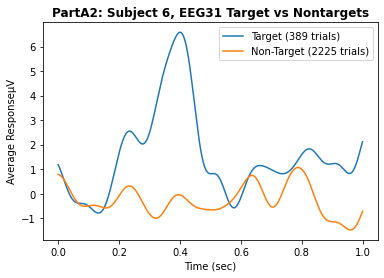

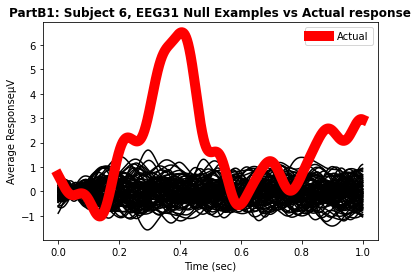

In [23]:
##PLOTS 
# time = np.arange(0,len(NewData[1])/fs,1/fs)
t = np.arange(0,1,1/fs)


#1st epoch
# plt.figure()
# for i in range(0,data.shape[0]):
#     plt.plot(time[820:820+2048],data[0][820:+2048])
# plt.xlabel('Time (sec)')
# plt.ylabel(u'\u03bcV')
# plt.title('EEG 1st Epoch',fontweight='bold')

#FilteredData
# plt.figure()
# for i in range(0,NewData.shape[0]):
#     plt.plot(time[820:820+2048],FilterData[i][820:820+2048]) #Plot the signal
# plt.xlabel('Time (sec)')
# plt.ylabel(u'\u03bcV')
# plt.title('EEG Filtered Data',fontweight='bold')

#TARGET AND NONTARGET DATA partA
plt.figure()
plt.plot(t,avgEEGtarget[FzEEG], label= "Target (" + str(targetcount) + " trials)") #Plot the signal
plt.plot(t,avgnonEEGtarget[FzEEG], label= "Non-Target (" + str(nontargetcount) + " trials)") #Plot the signal) #Plot the signal
plt.xlabel('Time (sec)')
plt.ylabel('Average Response'u'\u03bcV')
plt.title('PartA2: Subject '+str(Subjects)+', EEG31 Target vs Nontargets',fontweight = 'bold')
plt.legend()
print(nontargetcount,'nontarget',targetcount,'target')

#100 NULLPERMUTATIONS part b2
plt.figure()
for i in range(0,100):
    plt.plot(t,difvalsFz[i], 'k') #Plot the signal) #Plot the signal
plt.plot(t,constantDifFz, 'r',linewidth = 10, label = "Actual") #Plot the signal
plt.xlabel('Time (sec)')
plt.ylabel('Average Response'u'\u03bcV')
plt.title('PartB1: Subject '+str(Subjects)+', EEG31 Null Examples vs Actual response',fontweight = 'bold')
plt.legend()